<a href="https://colab.research.google.com/github/tacla/Sistemas-Inteligentes/blob/main/ID3/Valida%C3%A7%C3%A3o_cruzada_com_%C3%A1rvores_indutivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VALIDAÇÃO CRUZADA
**Objetivo**: Explorar um algoritmo de aprendizado de máquina para compreender o método de validação cruzada e as métricas utilizadas para avaliar um modelo de classificação. Vamos iniciar pela importação das bibliotecas.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**(1) Geração de um dataset artificial**

Neste dataset gerado pela [make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html?highlight=make_moons#sklearn.datasets.make_moons) temos duas variáveis que caracterizam cada amostra, X0 e X1, e, para cada amostra, uma classe de saída binária (y). Isto significa que trabalharemos com exemplos positivos e negativos o que é chamado de aprendizado de conceito.

In [ ]:
# make_moons serve para gerar datasets de brincadeira para testes.
# Make moons gera duas regioes circulares de # exemplos positivos e negativos

# shuffle: boolean - embaralhar ou nao as amostras
# noise: desvio padrao de ruido Gaussiano
# random_star: se for int produz saidas identicas quando invocado diversas vezes
Xm, ym = make_moons(n_samples=1000, noise=0.3, random_state=42)
Xy = [[x0, x1, y] for x0, x1, y in zip(Xm[:,0], Xm[:,1], ym)]

# transforma os arrays Xm e ym em um dataframe do pandas
df = pd.DataFrame(Xy, columns = ['X0','X1','y'])
print("Amostras iniciais do dataframe")
print(df.head(3)) # imprime 3 amostras do dataframe

Amostras iniciais do dataframe
         X0        X1  y
0 -0.171863  0.596249  1
1  1.253283 -0.265414  1
2  0.723224  0.231943  1


**(2) Plotar as amostras**

Observar que as amostras formam duas regiões circulares com sobreposição definida pelo argumento *noise* em *make_moons*.

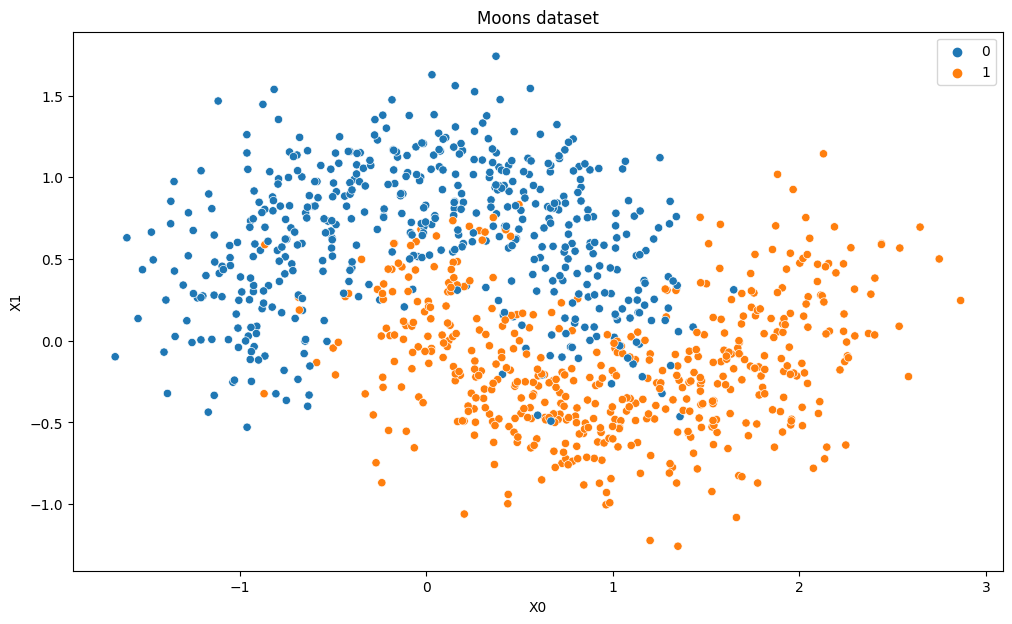

In [ ]:
# plot data
plt.figure(figsize=(12,7))

gr = sns.scatterplot(data=df, x="X0", y="X1", hue="y")
gr.set_title("Moons dataset")
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend()
plt.show()

**(3) Validação cruzada**

É um método para treinar/validar e testar modelos de aprendizado para evitar a sobreadaptação (*overfitting*) às amostras de treinamento.

SciKit possibilita separar o dataset em partes justamente para evitar este problema. Vamos fracionar o dataset em duas partes:
1.   para treinamento e validação
2.   para testes com dados não utilizados em 1


**Parêmetros importantes**:
* *test_size*: quanto do dataset será reservado para testes (entre 20-30%)
* *shuffle*: boolean; embaralha ou não antes de dividir (recomendável true)

Você pode fazer o fracionamento do dataset manualmente com a função train_test_split.

Vamos dividir o dataset em 70% para treinamento/validação e 30% para testes.
Documentação: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)

In [ ]:
## Dividir o dataset em treinamento/validação e teste
X_train, X_test, y_train, y_test = train_test_split(Xm, ym, test_size=0.25, shuffle=True)
print(f"Tamanho total do dataset: {len(Xm)}\n")
print(f"Dados de treinamento X ({len(X_train)}):\n{X_train[:3]} ...")
print(f"Dados de treinamento y:({len(y_train)})\n {y_train[:3]} ...")
print("---")
print(f"Dados de teste   X ({len(X_test)}):\n{X_test[:3]} ...")
print(f"Dados de teste   y:({len(y_test)})\n {y_test[:3]} ...")

Tamanho total do dataset: 1000

Dados de treinamento X (750):
[[ 0.77283735 -0.0381311 ]
 [ 1.59039768 -0.21789002]
 [ 0.22982569  0.69992037]] ...
Dados de treinamento y:(750)
 [0 1 1] ...
---
Dados de teste   X (250):
[[1.91667383 0.13496319]
 [0.47820102 0.61903534]
 [1.09161466 0.13865202]] ...
Dados de teste   y:(250)
 [1 0 0] ...


**(4) Experimento 001**

Cada experimento consiste em utilizar *n parametrizações* diferentes do algoritmo em k *folds*.

No nosso caso, vamos fazer [4 parametrizações diferentes](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) para a árvore de decisão que resulta de todas as combinações dos parâmetros abaixo:
* *criterio*: entropia
* *max_depth*: profundidade máxima da árvore: 10, 20
* *min_samples_leaf*:  número mínimo de amostras por folha; pode descartar ramificações de nós não folha: 4, 8

Cada experimento para treinamento consiste em rodar o algoritmo 1x para cada parametrização e, para cada parametrização, 1x para cada fold.

Vamos utilizar a função [GridSearchCV](https://colab.research.google.com/drive/1hSrqmmzphUlQRXmA__VMaged20a_tH1f?authuser=2#scrollTo=flNYY1YgSiea&line=11&uniqifier=1) que faz todas as combinações dos parâmetros e, também, a cross-validation (CV) com k-folds (vamos fazer k=3).

A **saída do código** produz uma linha por parametrização e por fold.

O **score** de comparação para a escolha do melhor modelo pode ser escolhido (ver opções neste [link](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)). No exemplo, vamos utilizar o f1 (média harmônica entre precisão e recall).

`F1 = 2 * (precision * recall) / (precision + recall)`

---



In [ ]:
parameters = {
    'criterion': ['entropy'],
    'max_depth': [2, 4],
    'min_samples_leaf': [8, 16, 32]
}

# instantiate model
model = DecisionTreeClassifier(random_state=42)

# grid search using cv
clf = GridSearchCV(model, parameters, cv=3, scoring='f1', verbose=4)
clf.fit(X_train, y_train)

best = clf.best_estimator_
print("\n* Melhor classificador *")
print(clf.best_estimator_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END criterion=entropy, max_depth=2, min_samples_leaf=8;, score=0.860 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, min_samples_leaf=8;, score=0.893 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, min_samples_leaf=8;, score=0.899 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, min_samples_leaf=16;, score=0.860 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, min_samples_leaf=16;, score=0.887 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, min_samples_leaf=16;, score=0.899 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=2, min_samples_leaf=32;, score=0.850 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=2, min_samples_leaf=32;, score=0.881 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=2, min_samples_leaf=32;, score=0.857 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=4, min_samples_leaf

**(5) Testar o modelo aprendido**

Agora, é possível rodar o modelo aprendido com os dados de teste (reservados anteriormente) e verificarmos as métricas de classificação.

Se a acurácia do treinamento/validação estiver muito maior do que a do teste, é um indício de que o modelo está sobreadaptado.


In [ ]:
# Predicoes
# com dados do treinamento
y_pred_train = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train) * 100
print(f"Acuracia com dados de treino: {acc_train:.2f}%")

y_pred_test = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test) * 100
print(f"Acuracia com dados de teste: {acc_test:.2f}%")

Acuracia com dados de treino: 89.47%
Acuracia com dados de teste: 84.40%


## ÁRVORE DE DECISÃO (MODELO APRENDIDO)

Agora vamos visualizar a árvore de melhor desempenho e algumas métricas para avaliar classificadores: matriz de confusão, precisão, recall e f-measure.

Na figura abaixo, observe em cada nó:
* X0 <= valor : condição sobre uma *feature*
* entropy: valor da entropia para o nó (nós folhas normalmente = zero)
* value: [amostras da classe 0, amostras da classe 1]
* class: mostra a classe mais numerosa do nó

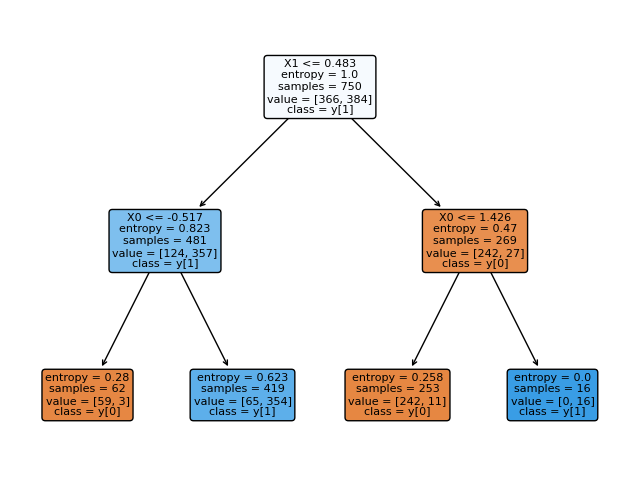

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(8, 6))
tree.plot_tree(best, feature_names=["X0", "X1"], filled=True, rounded=True, class_names=True, fontsize=8)
plt.show()

### MÉTRICAS PARA CLASSIFICADORES
Vamos analisar os resultados do teste.

***Matriz de confusão***: mostra o número de classificações corretas na diagonal principal. A partir dela, pode-se calcular precision, recall, taxa de verdadeiros positivos, ...

***Precision***: dentre os classificados como sendo classe zero quantos realmente são (idem para classe 1).

***Recall***: dentre todos os sabidos classe zero, quantos foram classificados como tal  (idem para classe 1).

***f1-score***: média harmônica entre precision e recall.

Todas estas métricas podem ser ponderadas pelo número de amostras de cada classe.
   

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       134
           1       0.78      0.93      0.85       116

    accuracy                           0.84       250
   macro avg       0.85      0.85      0.84       250
weighted avg       0.86      0.84      0.84       250



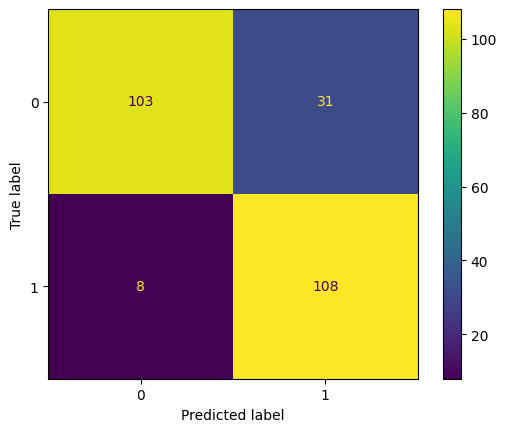

In [ ]:
# Matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test))


---

### **MATRIZ DE CONFUSÃO, PRECISION, RECALL E F1**

Vamos fazer uma matriz com dados estáticos para fins didáticos.
Considere que temos 5 amostras da classe 0 e 7 da classe 1. O classificador acerta:
* 4 da classe 0 (esses são os verdadeiros positivos)
* 5 da classe 1

Lendo coluna a coluna para calcularmos a precisão por classe (rode o código abaixo e veja a figura).

**Precisão = VP / (VP + FP)**
* classe 0, **Precisão, P0** = 4/6 = 0,666
* classe 1, **Precisão, P1** = 5/6 = 0,833
* média: 0,75

Lendo linha a linha para calcularmos o recall por classe:

**Recall = VP / (VP + FN)**
* classe 0, **Recall, R0** = 4/5 = 0,800
* classe 1, **Recall, R1** = 5/7 = 0,714
* média: 0,757
* média ponderada: (5.R0 + 7.R1)/12 = 0,75

**f1**
* classe 0: 2.P0.R0/(P0+R0) = 0,726
* classe 1: 2.P1.R1/(P1+R1) = 0,768
* média: 0,747
* f1 ponderado: (5.f1_0 + 7.f1_1)/12 = 0,7505

**Acuracidade geral**: 9/12 = 0,75


VP = Verdadeiro Positivo; FP = Falso Positivo; FN = Falso Negativo

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.83      0.71      0.77         7

    accuracy                           0.75        12
   macro avg       0.75      0.76      0.75        12
weighted avg       0.76      0.75      0.75        12



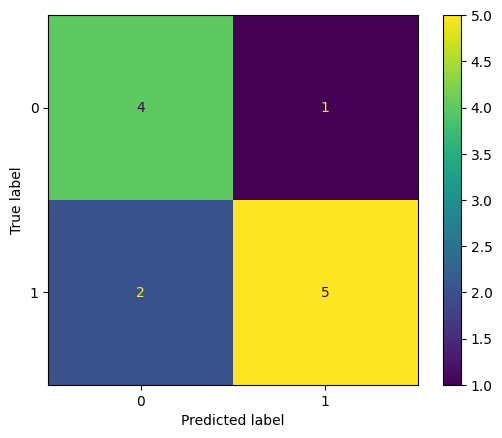

In [ ]:
y_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))